In [1]:
import requests
import json
import os
from PIL import Image
import base64
import pymongo
import numpy as np

mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
db = mongo_client["inference"]
jobs = db["jobs"]

## Load test image

In [2]:
assets_path = '../assets/test_data'
files = os.listdir(assets_path)
print(files)

['cow.jpeg', 'elephant.jpg', 'AM_DB9.jpg', 'table.jpeg', 'helmet.jpeg', 'fox.jpeg']


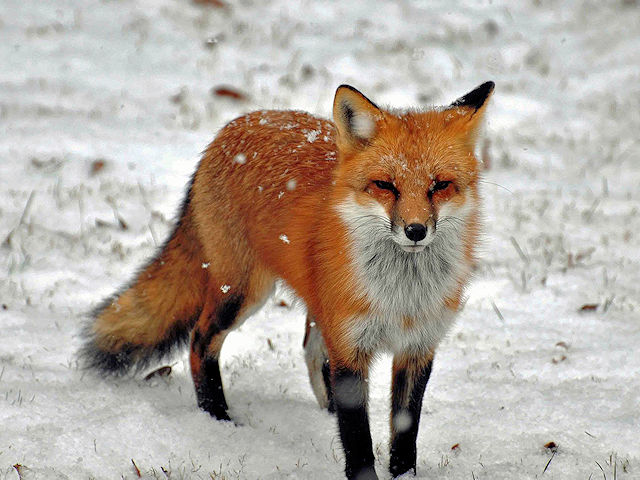

In [3]:
img_name = 'fox.jpeg'
img_path = os.path.join(assets_path, img_name)
img = Image.open(img_path)
img.convert('RGB')

## Execute inference job 

In [4]:
# Open image and apply Base 64 encoding
with open(img_path, 'rb') as img_file:
    encoded_img = base64.b64encode(img_file.read())
print(encoded_img[0:20])

b'/9j/4AAQSkZJRgABAQEA'


In [5]:
# Show available Jobs
job_collec = jobs.find({}).limit(1)

for job in job_collec:
    display(job)

{'_id': ObjectId('63bb63921f48251beb40bd5f'),
 'name': 'Test inf job',
 'status': 'NEW',
 'type': 'CLASSIFICATION'}

In [6]:
# Allocate/execute inference jobe
url = 'http://localhost:8080/api/v1/inference/jobs/63bb63921f48251beb40bd5f'

payload = {
    "image/jpeg": str(encoded_img)
}

response = requests.post(url, json=payload)
print(response)
display(response.json())

<Response [200]>


{'id': '63bb63921f48251beb40bd5f',
 'name': 'Test inf job',
 'status': 'NEW',
 'type': 'CLASSIFICATION'}

In [7]:
#response = re.get(url)

#response = requests.post(url, json=payload)
#preds = np.array(response.json()['predictions'])

#print(response.json())

## Test inference container exec_infer_jobs

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from io import BytesIO

2023-01-09 01:47:04.000068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 01:47:04.852230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-09 01:47:04.852301: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-09 01:47:04.852309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

#### Test first without encode and decode

In [9]:
img_size_Xc = (299, 299)
img = image.load_img(img_path, target_size=img_size_Xc)
x_Xc = image.img_to_array(img)
x_Xc = np.expand_dims(x_Xc, axis=0)
x_Xc = preprocess_input(x_Xc)

In [10]:
model_name = 'xception_classification'
url = 'http://localhost:8501/v1/models/' + model_name + ':predict'
payload = {
    "instances": x_Xc.tolist()
}
response = requests.post(url, json=payload)
preds = np.array(response.json()['predictions'])

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03942813', 'ping-pong_ball', 0.824734092), ('n02666196', 'abacus', 0.106219143), ('n03763968', 'military_uniform', 0.0443116762)]


#### Test with encoding and decoding

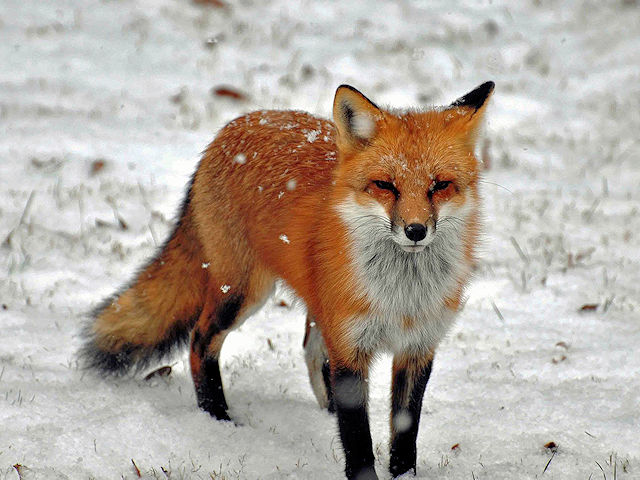

In [11]:
decoded_img = base64.b64decode(encoded_img)
img = Image.open(BytesIO(decoded_img))
img = img.convert('RGB')
img

In [12]:
print(len(encoded_img), encoded_img[0:10], encoded_img[-10:])
print(len(decoded_img), decoded_img[0:10], encoded_img[-10:])

121388 b'/9j/4AAQSk' b'kCgD//2Q=='
91039 b'\xff\xd8\xff\xe0\x00\x10JFIF' b'kCgD//2Q=='


In [13]:
print(len(encoded_img))

121388


In [98]:
print(len(decoded_img))

91039


In [88]:
img_size_Xc = (299, 299)
img_array = np.asarray(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.image.resize(img_array, img_size_Xc)
img_array = preprocess_input(img_array)

print(img_array.shape)

(1, 299, 299, 3)


In [89]:
model_name = 'xception_classification'
url = 'http://localhost:8501/v1/models/' + model_name + ':predict'
payload = {
    "instances": img_array.numpy().tolist()
}
response = requests.post(url, json=payload)
preds = np.array(response.json()['predictions'])

print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03942813', 'ping-pong_ball', 0.813916206), ('n02666196', 'abacus', 0.108605705), ('n03763968', 'military_uniform', 0.0322350934)]
